# Houses sale price prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.special import boxcox1p
from scipy.stats import skew

X = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

### Data Processing
- removing the outliers
- converting the target feature to log1p to make the distribution more gaussian shape

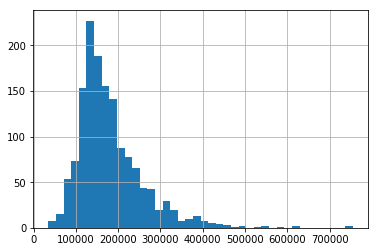

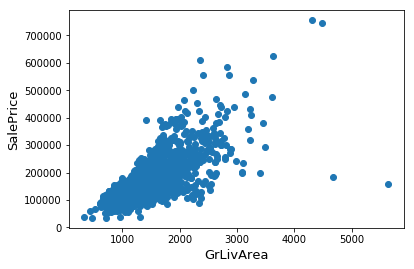

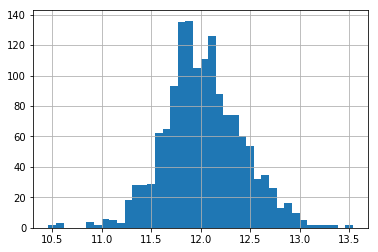

In [2]:
y = X['SalePrice'].reset_index(drop=True)

y.hist(bins = 40);
fig, ax = plt.subplots()
ax.scatter(X['GrLivArea'], y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

X = X[X.GrLivArea < 4500]
X.reset_index(drop=True, inplace=True)
y = np.log1p(X["SalePrice"]).reset_index(drop=True)
traincount = X.shape[0]
all_data = pd.concat((X, X_test_full),sort=False).reset_index(drop=True)

all_data.drop(['SalePrice'], axis=1, inplace=True)
y.hist(bins = 40);


filling in the NaN points with different methods depending on the feature. For example for the first set of following columns, the data description says that NaN simply means the house does not have that item. (Fence, Basement etc.)

Some features have very little diversity of values and loose their effect on the predictions. Therefore, they are dropped (Utilities)

In [3]:

for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature'):
    all_data[col]=all_data[col].fillna('NA')
    
for col in ('MasVnrType','MiscFeature'):
    all_data[col]=all_data[col].fillna('None')
    
for col in ('MSZoning','Exterior1st','Exterior2nd','SaleType'):
    all_data[col]=all_data[col].fillna(all_data[col].mode()[0])
    
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 


for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
            'BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea'):
    all_data[col]=all_data[col].fillna(0)
    
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")

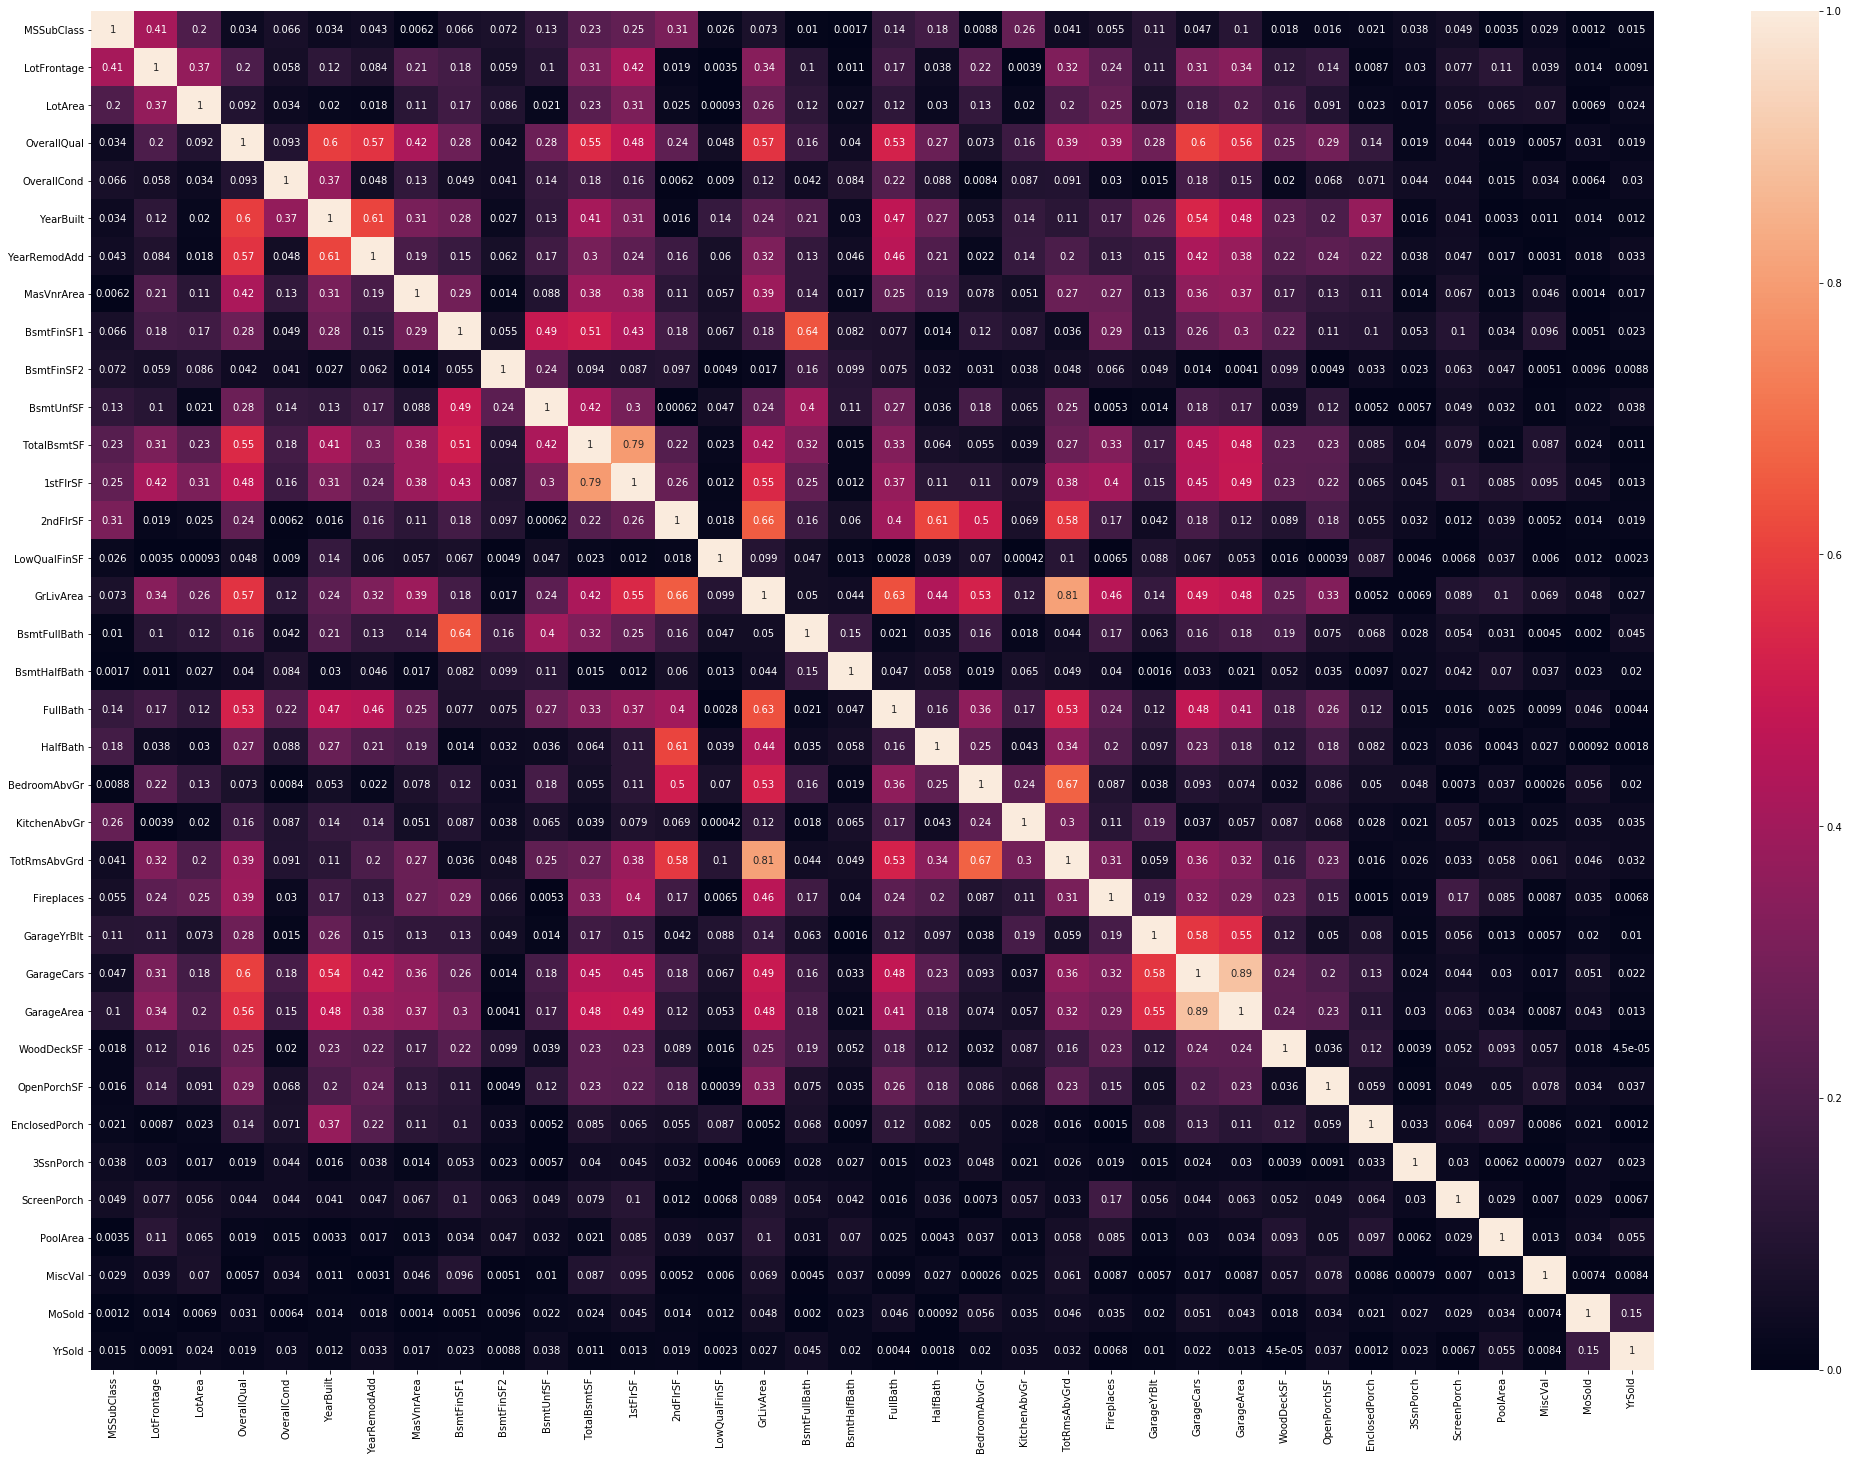

In [4]:
plt.figure(figsize=[35,25])
sns.heatmap(all_data.corr().abs(), annot=True);

- Checking the features correlations. 3 features are removed due to the highl correlaction with other existing features for the purpose of avoiding overfitting.

- A new feature is defined which shows the total square feet of each house with combining three other features.

- Also, there are a few numeric columns which should be treated as categorical data. Therefore, they are converted to string.

In [5]:
all_data['MSSubClass']=all_data['MSSubClass'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'], axis=1, inplace=True)

For the following ordinal values we convert the values to numerics to reduce computational cost and avoid overfitting in the next steps.

In [6]:
to_num=['ExterQual','ExterCond','KitchenQual','HeatingQC','BsmtQual',
        'BsmtCond','FireplaceQu','PoolQC','GarageQual','GarageCond']
def QualToInt(x):
    r=-1
    if(x=='Ex'):
        r = 5
    elif(x=='Gd'):
        r = 4
    elif(x=='TA'):
        r = 3
    elif(x=='Fa'):
        r = 2
    elif(x=='Po'):
        r = 1
    elif(x=='NA'):
        r = 0
    return r

for col in to_num:
    all_data[col] = all_data[col].apply(QualToInt)
    
def binary(x):
    r=-1
    if(x=='N'):
        r = 0
    elif(x=='Y'):
        r=1
    return r
all_data['CentralAir']=all_data['CentralAir'].apply(binary)

def lot(x):
    r=-1
    if(x=='Reg'):
        r = 4
    elif(x=='IR1'):
        r = 3
    elif(x=='IR2'):
        r = 2
    elif(x=='IR3'):
        r = 1
    return r
all_data['LotShape']=all_data['LotShape'].apply(lot)

def land(x):
    r=-1
    if(x=='Gtl'):
        r = 1
    elif(x=='Mod'):
        r = 2
    elif(x=='Sev'):
        r = 3
    return r
all_data['LandSlope']=all_data['LandSlope'].apply(land)

def basement(x):
    r=-1
    if(x=='GLQ'):
        r = 6
    elif(x=='ALQ'):
        r = 5
    elif(x=='BLQ'):
        r = 4
    elif(x=='Rec'):
        r = 3
    elif(x=='LwQ'):
        r = 2
    elif(x=='Unf'):
        r = 1
    elif(x=='NA'):
        r = 0
    return r

for col in ['BsmtFinType1','BsmtFinType2']:
    all_data[col]=all_data[col].apply(basement)
    
def expo(x):
    r=-1
    if(x=='Gd'):
        r = 4
    elif(x=='Av'):
        r = 3
    elif(x=='Mn'):
        r = 2
    elif(x=='No'):
        r = 1
    elif(x=='NA'):
        r = 0
    return r    

all_data['BsmtExposure']=all_data['BsmtExposure'].apply(expo)

def functionality(x):
    r=-1
    if(x=='Typ'):
        r = 7
    elif(x=='Min1'):
        r = 6
    elif(x=='Min2'):
        r = 5
    elif(x=='Mod'):
        r = 4
    elif(x=='Maj1'):
        r = 3
    elif(x=='Maj2'):
        r = 2
    elif(x=='Sev'):
        r = 1
    elif(x=='Sal'):
        r = 0
    return r

all_data['Functional']=all_data['Functional'].apply(functionality)

def garage(x):
    r=-1
    if(x=='Fin'):
        r = 3
    elif(x=='RFn'):
        r = 2
    elif(x=='Unf'):
        r = 1
    elif(x=='NA'):
        r = 0
    return r

all_data['GarageFinish']=all_data['GarageFinish'].apply(garage)


We check the skewness of the input features and apply the Box-Cox transformation on the skewed numerical features.

In [7]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolQC,19.548879
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344


In [8]:
skewness = skewness[abs(skewness) > 0]
print(skewness.shape[0])

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

49


Combining all the categorical and numerical features for both the training and the test data sets.

In [9]:
low_cardinality_cols = [cname for cname in all_data.columns if all_data[cname].
                        nunique() < 100 and all_data[cname].dtype == "object"]

numeric_cols = [cname for cname in all_data.columns if all_data[cname].dtype
                in ['int64', 'float64']]


my_cols = low_cardinality_cols + numeric_cols

final_data = all_data[my_cols].copy()
final_data = pd.get_dummies(final_data)
y_train=y


X_train = final_data[:traincount]
X_train.reset_index(drop=True, inplace=True)

X_test= final_data[traincount:]
X_test.reset_index(drop=True, inplace=True)

print(X_train.shape,X_test.shape)

(1458, 257) (1459, 257)


## Fitting Models

In [10]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor

In [11]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error",error_score='raise', cv = kf))
    return(rmse)

In [12]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))


In [13]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [14]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [15]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [16]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [17]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [18]:
scores={}
models=[lasso,ENet,KRR,GBoost,model_xgb]
names=['lasso','ENet','KRR','GBoost','model_xgb','model_lgb']

for i in range(len(models)):
    score = rmsle_cv(models[i]).mean()
    scores[names[i]]=score
scores

/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is de

{'lasso': 0.11276480197067129,
 'ENet': 0.11274655260936908,
 'KRR': 0.11557129880116006,
 'GBoost': 0.11670269194285092,
 'model_xgb': 0.11532413395653478}

### Averaging combination of models

In [19]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [20]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1092 (0.0044)



In [21]:
print(X_train.shape,X_test.shape)

(1458, 257) (1459, 257)


### Stacking previously discussed models

In [22]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y.values[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y.values)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [23]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1080 (0.0048)


In [24]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y_train, stacked_train_pred))


0.0774783124492079


In [25]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))

print(rmsle(y_train, xgb_train_pred))

/home/mahsa/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.07975844761498495


### Checking RMSE of the fitted models

In [26]:
lasso.fit(X_train, y_train)
lasso_train_pred = lasso.predict(X_train)
lasso_pred = np.expm1(lasso.predict(X_test))

print(rmsle(y_train, lasso_train_pred))

0.10181795709425759


In [27]:
ENet.fit(X_train, y_train)
ENet_train_pred = ENet.predict(X_train)
ENet_pred = np.expm1(ENet.predict(X_test))

print(rmsle(y_train, ENet_train_pred))

0.10132511950976407


In [28]:
KRR.fit(X_train, y_train)
KRR_train_pred = KRR.predict(X_train)
KRR_pred = np.expm1(KRR.predict(X_test))

print(rmsle(y_train, KRR_train_pred))

0.08684631629770283


In [29]:
GBoost.fit(X_train, y_train)
GBoost_train_pred = GBoost.predict(X_train)
GBoost_pred = np.expm1(GBoost.predict(X_test))

print(rmsle(y_train, GBoost_train_pred))

0.053155478181298295


In [30]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y_train, lgb_train_pred))

0.07379911888513359


### Combining the stacked models with XGB and LGB models

In [31]:
ensemble1 = 0.5*stacked_pred+0.25*xgb_pred+0.25*lgb_pred
ensemble2=stacked_pred
print(ensemble1,ensemble2)

[118600.25428919 161104.97822451 187526.22665583 ... 166374.56790037
 118727.63330446 218055.37665089] [116457.47305554 162951.05493829 188867.0070019  ... 166825.2109342
 117357.25638147 220653.16857713]


### Submission

In [32]:
sub = pd.DataFrame()
sub['Id'] = X_test_full.index
sub['SalePrice'] = ensemble1
sub.to_csv('submission.csv',index=False)